In [37]:
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
import scipy.io as sio
import os
import rasterio
from scipy.ndimage import uniform_filter
from mintpy.utils import ptime, readfile, writefile, isce_utils, utils as ut, plot as pp
from osgeo import osr
from mintpy.cli import geocode, view
from mintpy.spatial_filter import filter_data
from rasterio.windows import Window

plt.rcParams.update({'font.size': 12})

ds_name = ['S2_T046_20250228_20250330_EW', 'S2_T046_20250228_20250330_SN']
work_dir = '/home/hucy/penguin/Mandalay/autorift/20250228_20250330_new'
redo = True

os.chdir(work_dir)
print('Go to directory:', work_dir)

Go to directory: /home/hucy/penguin/Mandalay/autorift/20250228_20250330_new


In [38]:
def read_offset_attributes(tif_file):
    """
    使用rasterio读取tif文件的属性，返回与read_gdal_vrt兼容的字典
    """
    with rasterio.open(tif_file) as src:
        atr = {}
        
        # 基本信息
        atr['WIDTH'] = src.width
        atr['LENGTH'] = src.height
        atr['BANDS'] = src.count
        
        # 数据类型
        dtype = src.dtypes[0]
        atr['DATA_TYPE'] = dtype
        
        # 交错方式
        atr['INTERLEAVE'] = 'PIXEL'
        
        # 地理变换
        transform = src.transform
        atr['X_FIRST'] = transform.c
        atr['Y_FIRST'] = transform.f
        atr['X_STEP'] = transform.a
        atr['Y_STEP'] = -transform.e  # 注意y方向是负的
        
        # 坐标系统
        srs = osr.SpatialReference(wkt=src.crs.to_wkt())
        atr['EPSG'] = srs.GetAttrValue('AUTHORITY', 1)
        srs_name = srs.GetName()
        
        if srs_name and 'UTM' in srs_name:
            atr['UTM_ZONE'] = srs_name.split('UTM zone')[-1].strip()
            atr['X_UNIT'] = 'meters'
            atr['Y_UNIT'] = 'meters'
        elif abs(atr['X_STEP']) < 1. and abs(atr['X_STEP']) > 1e-7:
            atr['X_UNIT'] = 'degrees'
            atr['Y_UNIT'] = 'degrees'
            if atr['X_FIRST'] > 180.:
                atr['X_FIRST'] -= 360.
        
        # nodata值
        atr['NoDataValue'] = src.nodata
        
        return atr



In [39]:
# input files
off_file = os.path.join(work_dir, 'offset.tif')
loc_file = os.path.join(work_dir, 'window_location.tif')
atr = read_offset_attributes(off_file)

# output files
# rdr_file = os.path.join(work_dir, 'offEW.h5' if ds_name[0] else 'offSN.h5')
offew_file = os.path.join(work_dir, 'offEW.geo')
offsn_file = os.path.join(work_dir, 'offSN.geo')
offewStd_file = os.path.join(work_dir, 'offEWStd.geo')
offsnStd_file = os.path.join(work_dir, 'offSNStd.geo')
enuew_file = os.path.join(work_dir, 'enuEW.geo')
enusn_file = os.path.join(work_dir, 'enuSN.geo')

In [42]:
# read offsets
def read_offset_data(offset_file):
    """
    read offset.tif
    
    Parameters:
    offset_file: Path to offset.tif
    
    Return:
    offset: a numpy array of 4 bands
    """
    try:
        with rasterio.open(offset_file) as src:
            # Read all bands
            offset = src.read()
            
            # get nodata value
            nodata_value = src.nodata
            
            # extract metadata
            profile = src.profile
            
            print(f"File information:")
            print(f"Num of bands: {src.count}")
            print(f"File type: {src.dtypes}")
            print(f"nodata value: {nodata_value}")
            print(f"Image size: {src.width}x{src.height}")

            for i in range(2):
                # 创建掩码标识有效数据
                mask = offset[i] != nodata_value
                data = offset[i].copy()
                
                # 只对有效数据进行滤波
                valid_data = data[mask]
                if valid_data.size > 0:
                    # 应用中值滤波
                    filtered = filter_data(data, filter_type='median', filter_par=5)
                    # 保持无效数据区域不变
                    filtered[~mask] = nodata_value
                    offset[i] = filtered
                        
                print("Median filter applied to DX and DY bands")
            
            return offset, nodata_value
            
    except Exception as e:
        raise ValueError(f"Error whe reading offset: {str(e)}")

def calculate_local_std(data, window_size=5):
    """
    calculate_local_std
    data: input
    window_size: size of the slding window
    """
    # ingore NaN
    data = np.nan_to_num(data, nan=0.0)
    
    # calculate local mean
    local_mean = uniform_filter(data, size=window_size)
    # calculate local variance
    local_var = uniform_filter(data**2, size=window_size) - local_mean**2
    # calculate local std
    local_std = np.sqrt(np.maximum(local_var, 0))
    return local_std

def count_valid_pixels(data):
    return np.sum(~np.isnan(data))

def mask_autorift_offset(offset, nodata_value, config):
    """
    mask offset.tif generated by autoRIFT
    
    Parameters:
    offset: offset data read by read_offset_data
    nodata_value:
    config: 
        - max_off
        - max_std
        - window_size
    """
    
    EW_off = offset[0] * 10
    SN_off = offset[1] * 10
    interp_mask = offset[2]
    window_size = offset[3]
    
    EW_off_masked = np.array(EW_off, dtype=np.float32)
    SN_off_masked = np.array(SN_off, dtype=np.float32)
    
    # 1. mask nodata value
    EW_off_masked[EW_off == nodata_value] = np.nan
    SN_off_masked[SN_off == nodata_value] = np.nan
    print(f'# of pixels after removing no-data-value ({nodata_value}): {count_valid_pixels(EW_off_masked)} out of {EW_off.size} ({count_valid_pixels(EW_off_masked)/EW_off.size*100:.1f}%)')
    
    # # 2. Interp mask
    # EW_off_masked[interp_mask == 0] = np.nan
    # SN_off_masked[interp_mask == 0] = np.nan
    # print(f'# of pixels after removing interpolated pixels: {count_valid_pixels(EW_off_masked)} out of {EW_off.size} ({count_valid_pixels(EW_off_masked)/EW_off.size*100:.1f}%)')
    
    # 3. calculate local std
    EW_std = calculate_local_std(EW_off_masked, window_size=5)
    SN_std = calculate_local_std(SN_off_masked, window_size=5)
    
    # 4. mask abnormal offset
    EW_off_masked[np.abs(EW_off_masked) > config[ds_name[0]]['max_off']] = np.nan
    SN_off_masked[np.abs(SN_off_masked) > config[ds_name[1]]['max_off']] = np.nan
    print(f'# of pixels after removing offset > {config[ds_name[0]]["max_off"]}: {count_valid_pixels(EW_off_masked)} out of {EW_off.size} ({count_valid_pixels(EW_off_masked)/EW_off.size*100:.1f}%)')
    
    # 5. mask pixels with high offset std
    EW_off_masked[EW_std > config[ds_name[0]]['max_std']] = np.nan
    SN_off_masked[SN_std > config[ds_name[1]]['max_std']] = np.nan
    print(f'# of pixels after removing STD > {config[ds_name[0]]["max_std"]}: {count_valid_pixels(EW_off_masked)} out of {EW_off.size} ({count_valid_pixels(EW_off_masked)/EW_off.size*100:.1f}%)')
    
    return  EW_off_masked, SN_off_masked, EW_std, SN_std, EW_off, SN_off, interp_mask, window_size

print('Preparing functions...')

Preparing functions...


File information:
Num of bands: 4
File type: ('float32', 'float32', 'float32', 'float32')
nodata value: None
Image size: 8188x19938
Median filter applied to DX and DY bands
Median filter applied to DX and DY bands
# of pixels after removing no-data-value (None): 105759434 out of 163252344 (64.8%)
# of pixels after removing offset > 5: 105432916 out of 163252344 (64.6%)
# of pixels after removing STD > 0.5: 104753259 out of 163252344 (64.2%)


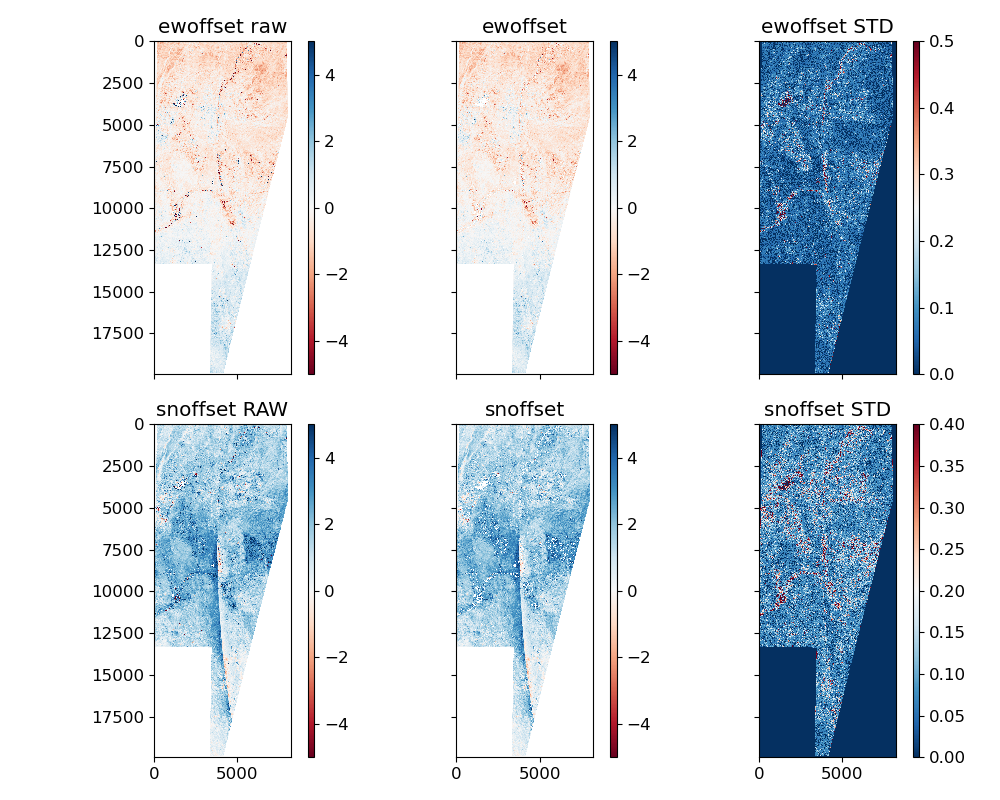

In [43]:
config = {
    'S2_T046_20250228_20250330_EW': {'max_off': 5, 'max_std': 0.5},
    'S2_T046_20250228_20250330_SN': {'max_off': 5, 'max_std': 0.4},
}

# read and mask
off_data, nodata_value = read_offset_data(off_file)
ew_off, sn_off, ewoff_std, snoff_std, ewoff_raw, snoff_raw, _, _ = mask_autorift_offset(off_data, nodata_value, config)

atr['FILE_TYPE'] = 'displacement'
# if redo or not os.path.isfile(rdr_file):
#     ds_dict      = {'displacement' : np.array(ew_off, dtype=np.float32), 'displacementStd' : np.array(ewoff_std, dtype=np.float32)}
#     ds_unit_dict = {'displacement' : 'm', 'displacementStd' : 'm'}
#     writefile.write(ds_dict, out_file=rdr_file, metadata=atr, ds_unit_dict=ds_unit_dict, compression='lzf', print_msg=False)

# plot
%matplotlib widget
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=[10, 8], sharex=True, sharey=True)

# prepare data
data_list = [ewoff_raw, ew_off, ewoff_std, snoff_raw, sn_off, snoff_std]
vmin_vmax_list = [[-5, 5], [-5, 5], [0, config[ds_name[0]]['max_std']], 
                  [-5, 5], [-5, 5], [0, config[ds_name[1]]['max_std']]]
cmap_list = ['RdBu', 'RdBu', 'RdBu_r', 'RdBu', 'RdBu', 'RdBu_r']
title_list = ['ewoffset raw', 'ewoffset', 'ewoffset STD', 
              'snoffset RAW', 'snoffset', 'snoffset STD']

for ax, data, (vmin, vmax), cmap, title in zip(axs.flatten(), 
                                              data_list, 
                                              vmin_vmax_list, 
                                              cmap_list, 
                                              title_list):
    im = ax.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax, interpolation='nearest')
    fig.colorbar(im, ax=ax, aspect=50)
    pp.auto_flip_direction(atr, ax, print_msg=False)
    ax.set_title(title)

fig.tight_layout()
plt.show()

In [44]:
def get_window_from_bounds(src, bounds):
    """
    Parameters:
    src: rasterio dataset
    bounds: (S, N, W, E) 
    """
    S, N, W, E = bounds
    row_start, col_start = src.index(W, N)  # Upper left
    row_end, col_end = src.index(E, S)      # Lower right
    
    # 确保窗口包含整个边界范围
    row_start = min(row_start, row_end)
    row_end = max(row_start, row_end)
    col_start = min(col_start, col_end)
    col_end = max(col_start, col_end)
    
    # 确保窗口在数据范围内
    row_start = max(0, min(row_start, src.height))
    row_end = max(0, min(row_end, src.height))
    col_start = max(0, min(col_start, src.width))
    col_end = max(0, min(col_end, src.width))

    height = abs(row_end - row_start)
    width = abs(col_end - col_start)
    return Window(col_start, row_start, width, height)

def save_geocoded_data(data, output_file, transform, crs, bounds, nodata=np.nan, metadata=None):
    """
    Save geocoded data to ENVI format file
    
    Parameters:
    data: Data array to save
    output_file: Output file path
    transform: rasterio transform object
    crs: Coordinate reference system
    bounds: Bounds in (S, N, W, E) format
    nodata: No-data value
    metadata: Optional metadata dictionary to override default values
    """
    import os
    import numpy as np
    from osgeo import gdal, osr
    from datetime import datetime
    import rasterio
    
    # Create output directory
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    
    # 解析边界和像素大小
    S, N, W, E = bounds
    pixel_size_x = abs(transform.a)
    pixel_size_y = abs(transform.e)
    
    # 计算目标图像大小
    width = int(round((E - W) / pixel_size_x))
    height = int(round((N - S) / pixel_size_y))
    
    # 创建目标数组
    data_expanded = np.full((height, width), nodata, dtype=data.dtype)
    
    # 获取原始数据在新网格中的位置
    with rasterio.open('window_location.tif') as src:
        # 获取源数据的边界
        src_bounds = src.bounds
        src_width = src.width
        src_height = src.height
        
        # 计算源数据和目标数据的重叠区域（在地理坐标中）
        overlap_w = max(W, src_bounds.left)
        overlap_e = min(E, src_bounds.right)
        overlap_s = max(S, src_bounds.bottom)
        overlap_n = min(N, src_bounds.top)
        
        if overlap_w < overlap_e and overlap_s < overlap_n:
            # 计算重叠区域在目标图像中的像素坐标
            target_x_start = int(round((overlap_w - W) / pixel_size_x))
            target_y_start = int(round((N - overlap_n) / pixel_size_y))
            target_x_end = int(round((overlap_e - W) / pixel_size_x))
            target_y_end = int(round((N - overlap_s) / pixel_size_y))
            
            # 计算重叠区域在源图像中的像素坐标
            source_x_start = int(round((overlap_w - src_bounds.left) / pixel_size_x))
            source_y_start = int(round((src_bounds.top - overlap_n) / pixel_size_y))
            source_x_end = int(round((overlap_e - src_bounds.left) / pixel_size_x))
            source_y_end = int(round((src_bounds.top - overlap_s) / pixel_size_y))
            
            # 确保坐标在有效范围内
            target_x_start = max(0, min(target_x_start, width))
            target_x_end = max(0, min(target_x_end, width))
            target_y_start = max(0, min(target_y_start, height))
            target_y_end = max(0, min(target_y_end, height))
            
            source_x_start = max(0, min(source_x_start, src_width))
            source_x_end = max(0, min(source_x_end, src_width))
            source_y_start = max(0, min(source_y_start, src_height))
            source_y_end = max(0, min(source_y_end, src_height))
            
            # 复制重叠区域的数据
            if (target_x_end > target_x_start and target_y_end > target_y_start and 
                source_x_end > source_x_start and source_y_end > source_y_start):
                data_expanded[target_y_start:target_y_end, target_x_start:target_x_end] = \
                    data[source_y_start:source_y_end, source_x_start:source_x_end]
    
    # 创建GDAL数据集
    driver = gdal.GetDriverByName('ENVI')
    ds = driver.Create(output_file, width, height, 1, gdal.GDT_Float32)
    if ds is None:
        raise ValueError(f"Cannot create output file: {output_file}")
    
    # 设置地理变换参数
    geotransform = (
        W,               # 左上角x坐标
        pixel_size_x,    # x方向像素大小
        0,              # 旋转参数
        N,               # 左上角y坐标
        0,              # 旋转参数
        -pixel_size_y    # y方向像素大小（负值表示北向上）
    )
    
    ds.SetGeoTransform(geotransform)
    
    # 设置投影
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(4326)  # WGS84
    ds.SetProjection(srs.ExportToWkt())
    
    # 写入数据
    band = ds.GetRasterBand(1)
    band.WriteArray(data_expanded)
    band.SetNoDataValue(nodata)
    
    # 准备元数据
    default_metadata = {
        'description': 'MintPy geo file',
        'samples': width,
        'lines': height,
        'bands': 1,
        'header offset': 0,
        'file type': 'ENVI Standard',
        'data type': 4,
        'interleave': 'bsq',
        'sensor type': 'Unknown',
        'byte order': 0,
        'map info': f'{{Geographic Lat/Lon, 1.0000, 1.0000, {W}, {N}, {pixel_size_x}, {pixel_size_y}, WGS-84, units=Degrees}}',
        'coordinate system string': '{{GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]}}',
        'band names': '{{band 1}}',
        'Y_FIRST': N,
        'X_FIRST': W,
        'Y_STEP': -pixel_size_y,
        'X_STEP': pixel_size_x,
        'Y_UNIT': 'degrees',
        'X_UNIT': 'degrees',
        'FILE_TYPE': 'geo',
        'DATA_TYPE': 'float32',
        'UNIT': 'm',
        'WIDTH': width,
        'LENGTH': height,
        'PROCESSOR': 'isce',
        'PROJECT_NAME': 'autoRIFT',
        'DATE12': "20250302_20250401",
        'REF_LAT': (N + S) / 2,
        'REF_LON': (W + E) / 2
    }
    
    if metadata:
        default_metadata.update(metadata)
    
    # 写入头文件
    hdr_file = output_file + '.hdr'
    with open(hdr_file, 'w') as f:
        f.write("ENVI\n")
        for key, value in default_metadata.items():
            if isinstance(value, str) and not value.startswith('{'):
                f.write(f"{key} = {value}\n")
            else:
                f.write(f"{key} = {value}\n")
    
    # 关闭数据集
    ds = None
    
    return data_expanded, geotransform

In [45]:
# grid
bounds = (16.5, 24, 94, 98)  # S, N, W, E
step = 0.000277777777778

# read window file for geo information
with rasterio.open('window_location.tif') as src:
    transform = src.transform
    crs = src.crs.to_wkt()
if redo:
    !rm *EW*
    !rm *SN*
# EW displacement
ew_data, ew_transform = save_geocoded_data(ew_off, offew_file, transform, crs, bounds)

# SN displacement
sn_data, sn_transform = save_geocoded_data(sn_off, offsn_file, transform, crs, bounds)

# EW displacement std
ew_std_data, ew_std_transform = save_geocoded_data(ewoff_std, offewStd_file, transform, crs, bounds)

# SN dispalcement std
offsnStd_file = os.path.join(work_dir, 'offSNStd.geo')
sn_std_data, sn_std_transform = save_geocoded_data(snoff_std, offsnStd_file, transform, crs, bounds)

print(f'Save EW displacement to: {offew_file}')
print(f'Save SN displacement to: {offsn_file}')
print(f'Save EW std to: {offewStd_file}')
print(f'Save SN std to: {offsnStd_file}')

Save EW displacement to: /home/hucy/penguin/Mandalay/autorift/20250228_20250330_new/offEW.geo
Save SN displacement to: /home/hucy/penguin/Mandalay/autorift/20250228_20250330_new/offSN.geo
Save EW std to: /home/hucy/penguin/Mandalay/autorift/20250228_20250330_new/offEWStd.geo
Save SN std to: /home/hucy/penguin/Mandalay/autorift/20250228_20250330_new/offSNStd.geo


view.py offEW.geo -c RdBu -v -5 5 --noverbose


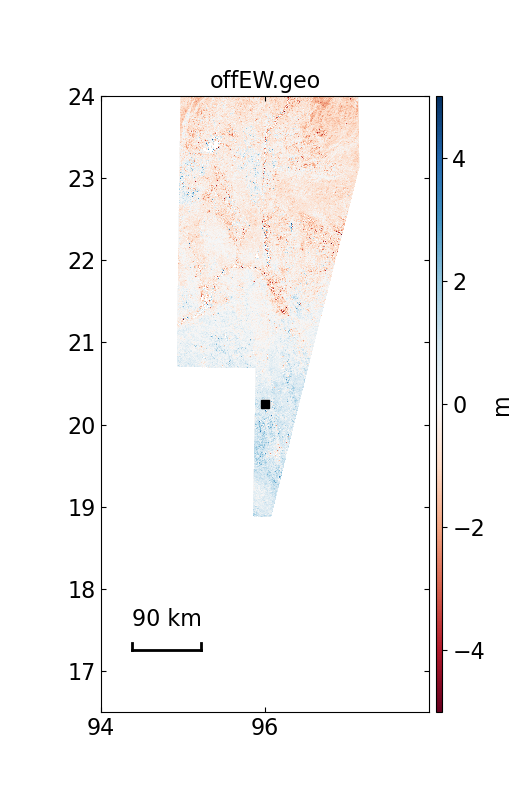

In [46]:
view.main(f'offEW.geo -c RdBu -v -5 5 --noverbose'.split())

view.py offSN.geo -c RdBu -v -5 5 --noverbose


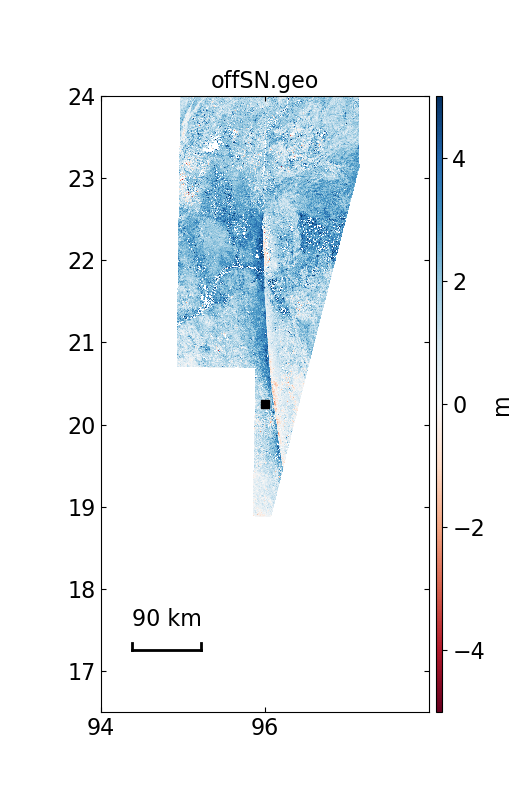

In [47]:
view.main(f'offSN.geo -c RdBu -v -5 5 --noverbose'.split())

In [61]:
def create_enu_files(ew_file, sn_file, output_ew_enu, output_sn_enu, transform, crs, bounds, metadata=None):
    """
    Create ENU unit vector files
    
    Parameters:
    ew_file: Path to EW displacement file (only used for getting dimensions and geographic info)
    sn_file: Path to SN displacement file (only used for getting dimensions and geographic info)
    output_ew_enu: Output path for EW direction ENU unit vector file
    output_sn_enu: Output path for SN direction ENU unit vector file
    transform: rasterio transform object
    crs: Coordinate reference system
    bounds: Bounds in (S, N, W, E) format
    metadata: Optional metadata dictionary to override default values
    """
    import numpy as np
    from osgeo import gdal, osr
    import os
    from datetime import datetime
    
    # 解析边界和像素大小
    S, N, W, E = bounds
    pixel_size_x = abs(transform.a)
    pixel_size_y = abs(transform.e)
    
    # 计算目标图像大小
    width = int(round((E - W) / pixel_size_x))
    height = int(round((N - S) / pixel_size_y))
    
    # Get center latitude and longitude
    center_lat = (N + S) / 2
    center_lon = (W + E) / 2
    
    # Try to get date information from input files
    try:
        # Extract date from input filenames
        ew_date = os.path.basename(ew_file).split('.')[0]
        sn_date = os.path.basename(sn_file).split('.')[0]
        if '_' in ew_date and '_' in sn_date:
            date12 = f"{ew_date}_{sn_date}"
        else:
            # If no date information, use current date
            today = datetime.now().strftime('%Y%m%d')
            date12 = f"{today}_{today}"
    except:
        date12 = "20250302_20250401"  # Default value
    
    # Create ENU files
    for output_file, is_ew in [(output_ew_enu, True), (output_sn_enu, False)]:
        # Create unit vectors for the entire target region
        ones = np.ones((height, width))
        zeros = np.zeros((height, width))
        
        # Prepare data
        if is_ew:
            # EW direction unit vector [1, 0, 0]
            data_3d = np.stack([ones, zeros, zeros])  # [east, north, up]
        else:
            # SN direction unit vector [0, 1, 0]
            data_3d = np.stack([zeros, ones, zeros])  # [east, north, up]
        
        # Create GDAL dataset
        driver = gdal.GetDriverByName('ENVI')
        
        # Create output directory
        os.makedirs(os.path.dirname(output_file), exist_ok=True)
        
        # Create file
        ds = driver.Create(output_file, width, height, 3, gdal.GDT_Float32)
        if ds is None:
            raise ValueError(f"Cannot create output file: {output_file}")
        
        # Set geotransform
        geotransform = (
            W,               # 左上角x坐标
            pixel_size_x,    # x方向像素大小
            0,              # 旋转参数
            N,               # 左上角y坐标
            0,              # 旋转参数
            -pixel_size_y    # y方向像素大小（负值表示北向上）
        )
        ds.SetGeoTransform(geotransform)
        
        # Set projection
        srs = osr.SpatialReference()
        srs.ImportFromEPSG(4326)  # WGS84
        ds.SetProjection(srs.ExportToWkt())
        
        # Write data
        for i in range(3):
            band = ds.GetRasterBand(i+1)
            band.WriteArray(data_3d[i])
            band.SetNoDataValue(np.nan)
        
        # Prepare metadata
        default_metadata = {
            'description': 'MintPy geo file',
            'samples': width,
            'lines': height,
            'bands': 3,
            'header offset': 0,
            'file type': 'ENVI Standard',
            'data type': 4,
            'interleave': 'bsq',
            'sensor type': 'Unknown',
            'byte order': 0,
            'map info': f'{{Geographic Lat/Lon, 1.0000, 1.0000, {W}, {N}, {pixel_size_x}, {pixel_size_y}, WGS-84, units=Degrees}}',
            'coordinate system string': '{{GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]}}',
            'band names': '{{East, North, Up}}',
            'Y_FIRST': N,
            'X_FIRST': W,
            'Y_STEP': -pixel_size_y,
            'X_STEP': pixel_size_x,
            'Y_UNIT': 'degrees',
            'X_UNIT': 'degrees',
            'FILE_TYPE': 'geo',
            'DATA_TYPE': 'float32',
            'UNIT': 'm',
            'WIDTH': width,
            'LENGTH': height,
            'PROCESSOR': 'isce',
            'PROJECT_NAME': 'autoRIFT',
            'DATE12': date12,
            'REF_LAT': center_lat,
            'REF_LON': center_lon
        }
        
        # Update default metadata with user-provided metadata if any
        if metadata:
            default_metadata.update(metadata)
        
        # Write .hdr file
        hdr_file = output_file + '.hdr'
        with open(hdr_file, 'w') as f:
            f.write("ENVI\n")
            for key, value in default_metadata.items():
                if isinstance(value, str) and not value.startswith('{'):
                    f.write(f"{key} = {value}\n")
                else:
                    f.write(f"{key} = {value}\n")
        
        # Close dataset
        ds = None

In [62]:
create_enu_files(
    ew_file=offew_file,
    sn_file=offsn_file,
    output_ew_enu=enuew_file,
    output_sn_enu=enusn_file,
    transform=transform,
    crs=crs,
    bounds=bounds
)

view.py enuSN.geo band1 --noverbose


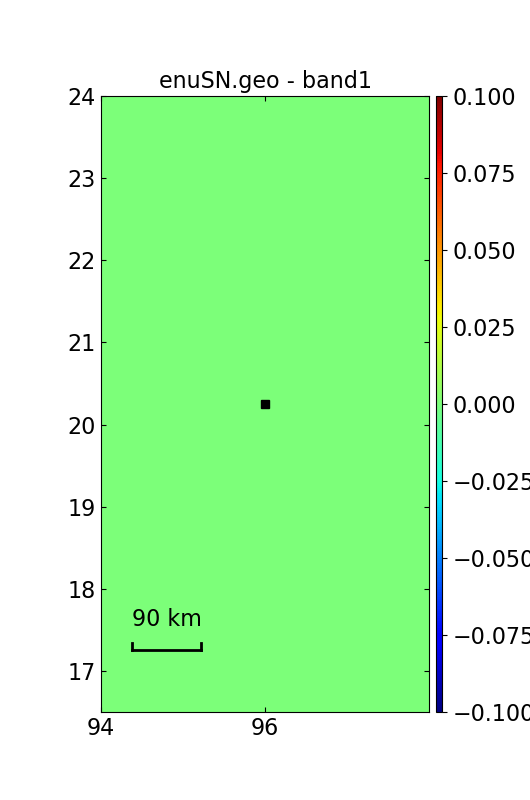

In [63]:
view.main(f'enuSN.geo band1 --noverbose'.split())

view.py enuSN.geo band2 --noverbose


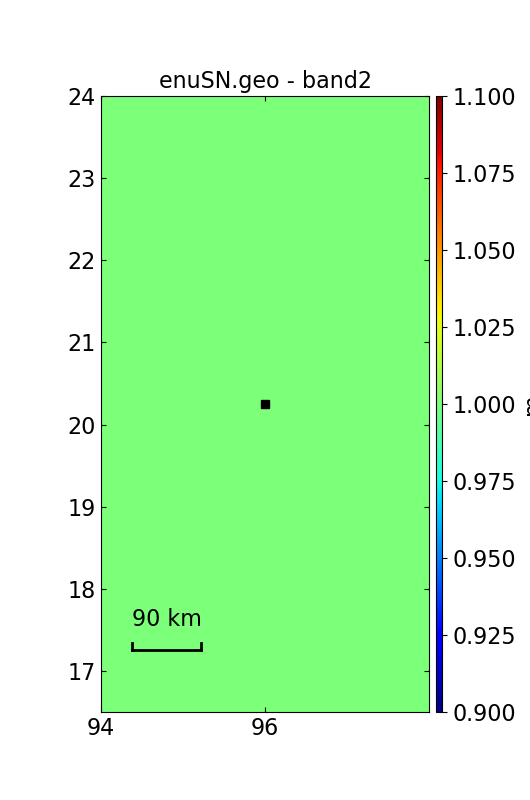

In [64]:
view.main(f'enuSN.geo band2 --noverbose'.split())

In [65]:
print('create xml and rsc files')
atr = readfile.read_attribute(offew_file)
writefile.write_isce_xml(atr, offew_file)
writefile.write_roipac_rsc(atr,offew_file+'.rsc')
atr = readfile.read_attribute(offsn_file)
writefile.write_isce_xml(atr, offsn_file)
writefile.write_roipac_rsc(atr,offsn_file+'.rsc')
atr = readfile.read_attribute(offewStd_file)
writefile.write_isce_xml(atr, offewStd_file)
writefile.write_roipac_rsc(atr,offewStd_file+'.rsc')
atr = readfile.read_attribute(offsnStd_file)
writefile.write_isce_xml(atr, offsnStd_file)
writefile.write_roipac_rsc(atr,offsnStd_file+'.rsc')
atr = readfile.read_attribute(enuew_file)
writefile.write_isce_xml(atr, enuew_file)
writefile.write_roipac_rsc(atr,enuew_file+'.rsc')
atr = readfile.read_attribute(enusn_file)
writefile.write_isce_xml(atr, enusn_file)
writefile.write_roipac_rsc(atr,enusn_file+'.rsc')

create xml and rsc files
write file: /home/hucy/penguin/Mandalay/autorift/20250228_20250330_new/offEW.geo.xml
write file: /home/hucy/penguin/Mandalay/autorift/20250228_20250330_new/offEW.geo.vrt
write file: /home/hucy/penguin/Mandalay/autorift/20250228_20250330_new/offSN.geo.xml
write file: /home/hucy/penguin/Mandalay/autorift/20250228_20250330_new/offSN.geo.vrt
write file: /home/hucy/penguin/Mandalay/autorift/20250228_20250330_new/offEWStd.geo.xml
write file: /home/hucy/penguin/Mandalay/autorift/20250228_20250330_new/offEWStd.geo.vrt
write file: /home/hucy/penguin/Mandalay/autorift/20250228_20250330_new/offSNStd.geo.xml
write file: /home/hucy/penguin/Mandalay/autorift/20250228_20250330_new/offSNStd.geo.vrt
write file: /home/hucy/penguin/Mandalay/autorift/20250228_20250330_new/enuEW.geo.xml
write file: /home/hucy/penguin/Mandalay/autorift/20250228_20250330_new/enuEW.geo.vrt
write file: /home/hucy/penguin/Mandalay/autorift/20250228_20250330_new/enuSN.geo.xml
write file: /home/hucy/pengu

'/home/hucy/penguin/Mandalay/autorift/20250228_20250330_new/enuSN.geo.rsc'

run view.py in MintPy version 1.6.1, date 2024-07-31
input file is isce offEW file: /penguin/hucy/Mandalay/autorift/20250228_20250330_new/offEW.geo in float32 format
file size in y/x: (27000, 14400)
num of datasets in file offEW.geo: 1
datasets to exclude (0):
[]
datasets to display (1):
['band1']
data   coverage in y/x: (0, 0, 14400, 27000)
subset coverage in y/x: (0, 0, 14400, 27000)
data   coverage in lat/lon: (93.99986111111112, 24.000138888888888, 97.99986111111113, 16.50013888888888)
subset coverage in lat/lon: (93.99986111111112, 24.000138888888888, 97.99986111111113, 16.50013888888888)
------------------------------------------------------------------------
area exceed 2000 pixels, turn off default DEM contour display
colormap: RdBu
initiate cartopy map projection: PlateCarree
figure title: S2_T046_20250228_20250330_EW
figure size : [5.3, 8.0]
reading data ...
data    range: [-5.0, 5.0] m
display range: [-4.0, 4.0] m
reading DEM: elevation_mli.dem ...
display data in transparen

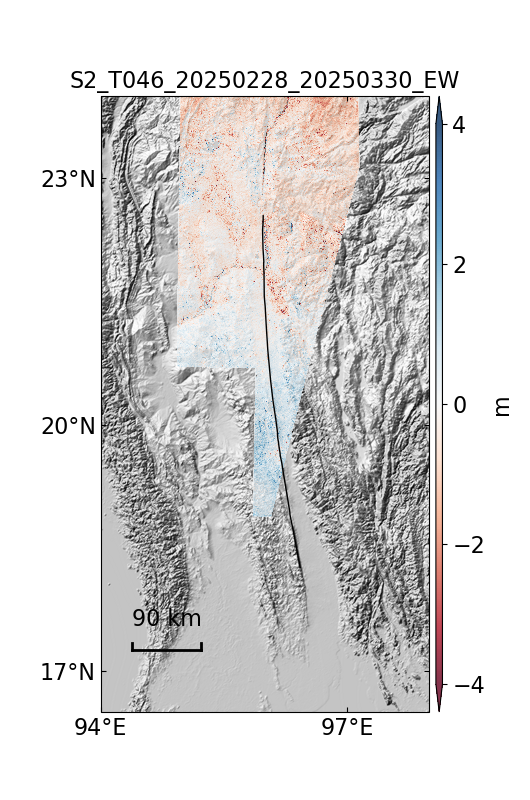

In [53]:
dis_file = f'offEW.geo'
dem_file = os.path.join(f'/home/eedy/penguin/25EQ_myanmar/DEM/elevation_mli.dem')
flt_file = os.path.join(f'/home/eedy/penguin/25EQ_myanmar/simple_rupture_trace.lonlat')
out_file = os.path.join(work_dir, f'{dis_file}.png')
cmd = f'{dis_file} --dem {dem_file} --dem-nocontour --shade-exag 0.05 --faultline {flt_file} --faultline-lw 1 '
cmd += f'-c RdBu -v -4 4 --lalo-label --lalo-step 3 --cbar-nbins 5 --scalebar 0.2 0.20 0.10 --title {ds_name[0]} --noreference '
cmd += f'-o {out_file} '
view.main(cmd.split())

run view.py in MintPy version 1.6.1, date 2024-07-31
input file is isce offSN file: /penguin/hucy/Mandalay/autorift/20250228_20250330_new/offSN.geo in float32 format
file size in y/x: (27000, 14400)
num of datasets in file offSN.geo: 1
datasets to exclude (0):
[]
datasets to display (1):
['band1']
data   coverage in y/x: (0, 0, 14400, 27000)
subset coverage in y/x: (0, 0, 14400, 27000)
data   coverage in lat/lon: (93.99986111111112, 24.000138888888888, 97.99986111111113, 16.50013888888888)
subset coverage in lat/lon: (93.99986111111112, 24.000138888888888, 97.99986111111113, 16.50013888888888)
------------------------------------------------------------------------
area exceed 2000 pixels, turn off default DEM contour display
colormap: RdBu
initiate cartopy map projection: PlateCarree
figure title: S2_T046_20250228_20250330_SN
figure size : [5.3, 8.0]
reading data ...
data    range: [-5.0, 5.0] m
display range: [-4.0, 4.0] m
reading DEM: elevation_mli.dem ...
display data in transparen

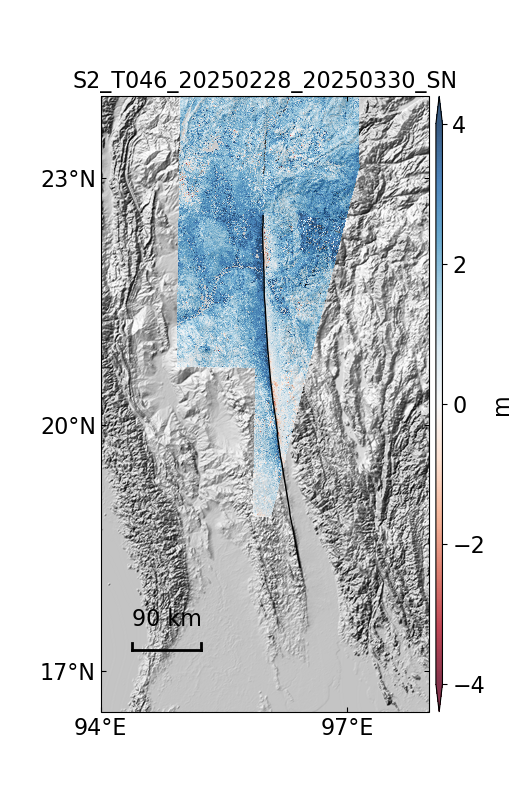

In [54]:
dis_file = f'offSN.geo'
dem_file = os.path.join(f'/home/eedy/penguin/25EQ_myanmar/DEM/elevation_mli.dem')
flt_file = os.path.join(f'/home/eedy/penguin/25EQ_myanmar/simple_rupture_trace.lonlat')
out_file = os.path.join(work_dir, f'{dis_file}.png')
cmd = f'{dis_file} --dem {dem_file} --dem-nocontour --shade-exag 0.05 --faultline {flt_file} --faultline-lw 1 '
cmd += f'-c RdBu -v -4 4 --lalo-label --lalo-step 3 --cbar-nbins 5 --scalebar 0.2 0.20 0.10 --title {ds_name[1]} --noreference '
cmd += f'-o {out_file} '
view.main(cmd.split())

remove linear ramp from file: offSN.geo
read mask file: mask_deramp.h5
writing >>> offSNtest.geo
write file: offSNtest.geo
write file: offSNtest.geo.rsc
add/update the following metadata to file:
add/update mintpy.deramp = linear
add/update mintpy.deramp.maskFile = mask_deramp.h5
write file: offSNtest.geo.rsc
time used: 00 mins 21.1 secs.
view.py offSNtest.geo -c RdBu -v -5 5 --noverbose


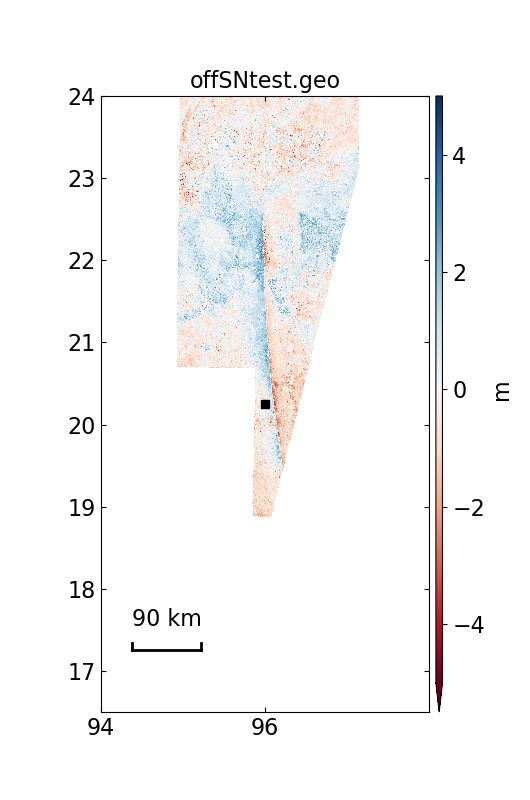

In [55]:
!remove_ramp.py offSN.geo -o offSNtest.geo -m mask_deramp.h5
view.main(f'offSNtest.geo -c RdBu -v -5 5 --noverbose'.split())

remove linear ramp from file: offEW.geo
read mask file: mask_deramp.h5
writing >>> offEWtest.geo
write file: offEWtest.geo
write file: offEWtest.geo.rsc
add/update the following metadata to file:
add/update mintpy.deramp = linear
add/update mintpy.deramp.maskFile = mask_deramp.h5
write file: offEWtest.geo.rsc
time used: 00 mins 19.0 secs.
view.py offEWtest.geo -c RdBu -v -5 5 --noverbose


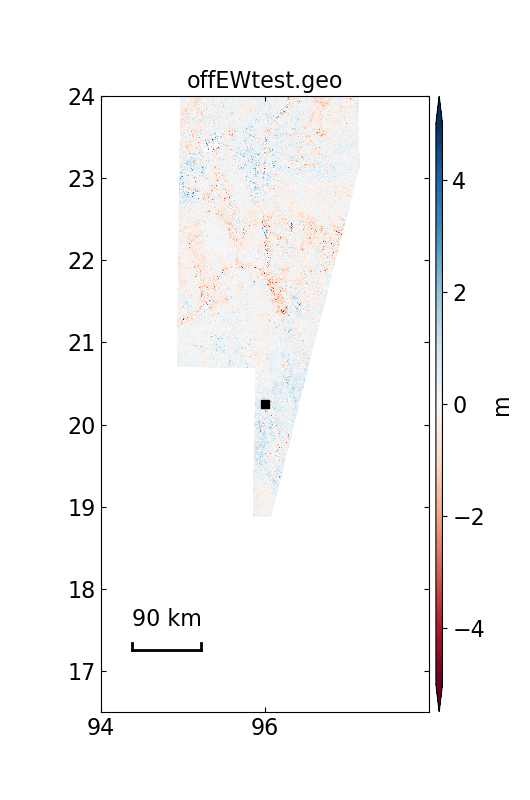

In [56]:
!remove_ramp.py offEW.geo -o offEWtest.geo -m mask_deramp.h5
view.main(f'offEWtest.geo -c RdBu -v -5 5 --noverbose'.split())

run view.py in MintPy version 1.6.1, date 2024-07-31
input file is isce offEW file: /penguin/hucy/Mandalay/autorift/20250228_20250330_new/offEWtest.geo in float32 format
file size in y/x: (27000, 14400)
num of datasets in file offEWtest.geo: 1
datasets to exclude (0):
[]
datasets to display (1):
['band1']
data   coverage in y/x: (0, 0, 14400, 27000)
subset coverage in y/x: (0, 0, 14400, 27000)
data   coverage in lat/lon: (93.99986111111112, 24.000138888888888, 97.99986111111113, 16.50013888888888)
subset coverage in lat/lon: (93.99986111111112, 24.000138888888888, 97.99986111111113, 16.50013888888888)
------------------------------------------------------------------------
area exceed 2000 pixels, turn off default DEM contour display
colormap: RdBu
initiate cartopy map projection: PlateCarree
figure title: S2_T046_20250228_20250330_EW
figure size : [5.3, 8.0]
reading data ...
data    range: [-5.4878674, 5.8789244] m
display range: [-4.0, 4.0] m
reading DEM: elevation_mli.dem ...
displa

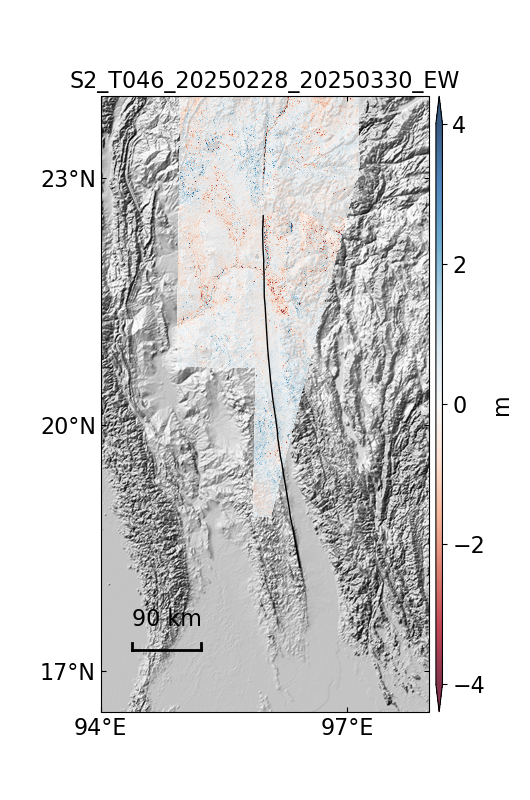

In [57]:
dis_file = f'offEWtest.geo'
dem_file = os.path.join(f'/home/eedy/penguin/25EQ_myanmar/DEM/elevation_mli.dem')
flt_file = os.path.join(f'/home/eedy/penguin/25EQ_myanmar/simple_rupture_trace.lonlat')
out_file = os.path.join(work_dir, f'{dis_file}deramp.png')
cmd = f'{dis_file} --dem {dem_file} --dem-nocontour --shade-exag 0.05 --faultline {flt_file} --faultline-lw 1 '
cmd += f'-c RdBu -v -4 4 --lalo-label --lalo-step 3 --cbar-nbins 5 --scalebar 0.2 0.20 0.10 --title {ds_name[0]} --noreference '
cmd += f'-o {out_file} '
view.main(cmd.split())

run view.py in MintPy version 1.6.1, date 2024-07-31
input file is isce offSN file: /penguin/hucy/Mandalay/autorift/20250228_20250330_new/offSNtest.geo in float32 format
file size in y/x: (27000, 14400)
num of datasets in file offSNtest.geo: 1
datasets to exclude (0):
[]
datasets to display (1):
['band1']
data   coverage in y/x: (0, 0, 14400, 27000)
subset coverage in y/x: (0, 0, 14400, 27000)
data   coverage in lat/lon: (93.99986111111112, 24.000138888888888, 97.99986111111113, 16.50013888888888)
subset coverage in lat/lon: (93.99986111111112, 24.000138888888888, 97.99986111111113, 16.50013888888888)
------------------------------------------------------------------------
area exceed 2000 pixels, turn off default DEM contour display
colormap: RdBu
initiate cartopy map projection: PlateCarree
figure title: S2_T046_20250228_20250330_SN
figure size : [5.3, 8.0]
reading data ...
data    range: [-6.9225073, 3.5276933] m
display range: [-4.0, 4.0] m
reading DEM: elevation_mli.dem ...
displa

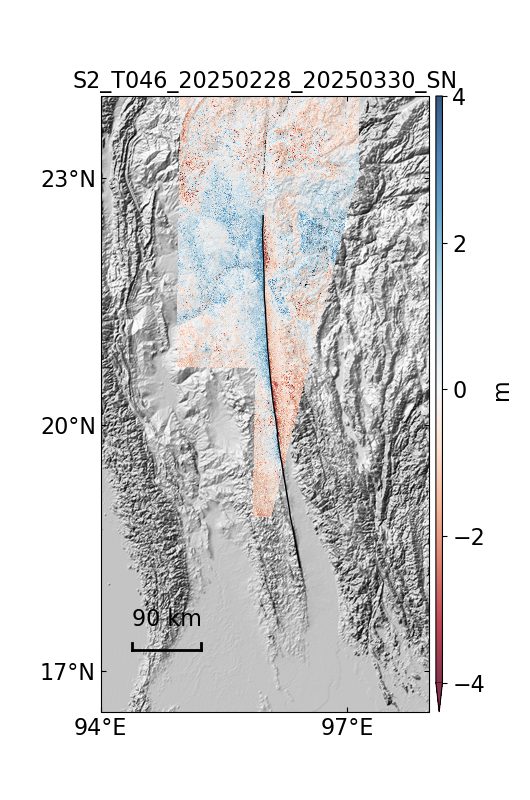

In [58]:
dis_file = f'offSNtest.geo'
dem_file = os.path.join(f'/home/eedy/penguin/25EQ_myanmar/DEM/elevation_mli.dem')
flt_file = os.path.join(f'/home/eedy/penguin/25EQ_myanmar/simple_rupture_trace.lonlat')
out_file = os.path.join(work_dir, f'{dis_file}deramp.png')
cmd = f'{dis_file} --dem {dem_file} --dem-nocontour --shade-exag 0.05 --faultline {flt_file} --faultline-lw 1 '
cmd += f'-c RdBu -v -4 4 --lalo-label --lalo-step 3 --cbar-nbins 5 --scalebar 0.2 0.20 0.10 --title {ds_name[1]} --noreference '
cmd += f'-o {out_file} '
view.main(cmd.split())

write file: offEWRAMP.geo
write file: offEWRAMP.geo.rsc
view.py offEWRAMP.geo -c RdBu -v -5 5 --noverbose --save --noreference


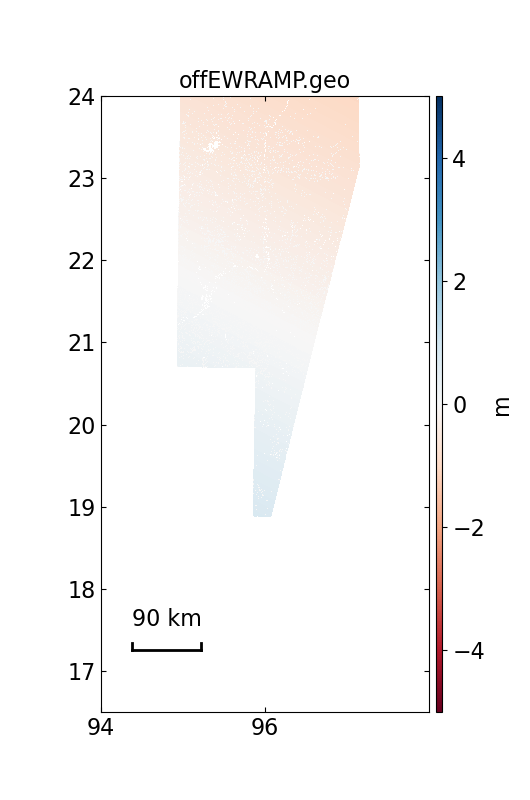

In [59]:
ramp = readfile.read(f'offEW.geo')[0] - readfile.read(f'offEWtest.geo')[0]
atr = readfile.read_attribute(f'offEW.geo')
ramp_file = writefile.write(ramp, out_file=f'offEWRAMP.geo', metadata=atr)
view.main(f'offEWRAMP.geo -c RdBu -v -5 5 --noverbose --save --noreference'.split())

write file: offSNRAMP.geo
write file: offSNRAMP.geo.rsc
view.py offSNRAMP.geo -c RdBu -v -5 5 --noverbose --save --noreference


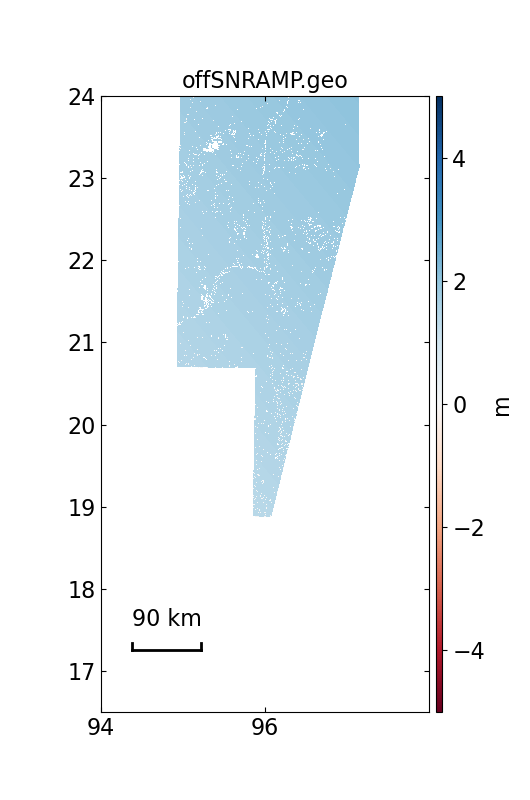

In [60]:
ramp = readfile.read(f'offSN.geo')[0] - readfile.read(f'offSNtest.geo')[0]
atr = readfile.read_attribute(f'offSN.geo')
ramp_file = writefile.write(ramp, out_file=f'offSNRAMP.geo', metadata=atr)
view.main(f'offSNRAMP.geo -c RdBu -v -5 5 --noverbose --save --noreference'.split())